In [1]:
import numpy as np
import torch, sys
from torchvision.transforms import functional as func
import torchvision.transforms as transforms
from loss import ComputeLoss
import yaml, random
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from new_model import Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
from torch.utils.data import DataLoader

from dataloader import FiftyOneTorchDataset, collate_fn
from util import non_max_suppression


Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
dataset_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    # label_types=[""],
    classes=["cat", "dog", "horse", "giraffe"],
    max_samples=100,
)

Found annotations at '/home/jil1119/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:

dataset_validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    # label_types=[""],
    classes=["cat", "dog", "horse", "giraffe"],
    max_samples=20,
)

Found annotations at '/home/jil1119/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-20'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:

dataset_train.persistent = True
dataset_validation.persistent = True
view_train = dataset_train.filter_labels("ground_truth", F("label").is_in(("cat", "dog", "horse", "giraffe")))
view_val = dataset_validation.filter_labels("ground_truth", F("label").is_in(("cat", "dog", "horse", "giraffe")))



fil_classes = ["cat", "dog", "horse", "giraffe"]
device = torch.device('cuda:0')

with open("hyp.yaml", "r") as stream:
    try:
        hyp = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


org_w = 640
org_h = 480
scaling_factor = 640/480

batch_size = 8

transform = transforms.Compose([transforms.Resize((int(org_h/scaling_factor), int(org_w/scaling_factor))),
                                transforms.Pad((0, int((org_w - org_h)/(2*scaling_factor)),0,int((org_w - org_h)/(2*scaling_factor)))),
                                transforms.ToTensor()])
            
dataset_train = FiftyOneTorchDataset(view_train, transform, classes=fil_classes)
dataset_val = FiftyOneTorchDataset(view_val, transform, classes=fil_classes)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)



In [5]:
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [6]:

model = Model('yolov3.yaml', hyp=hyp).to(device)

optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fcn = ComputeLoss(model)
#training
train_loss_list = []
val_loss_list = []
# Add predictions to samples\
epochs = 100
for epoch in range(epochs):
    #training
    tot_loss = 0
    count = 0
    for images, targets in loader_train:
        model.train()
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss, loss_parts = loss_fcn(preds, targets)
        tot_loss += loss / batch_size
        count += 1
        loss.backward()
        optimizer.step()
        
    #save the model each 50 epochs
    if epoch%10==0 and epoch!=0:
        torch.save(model,'./models/model'+str(epoch)+'.pt')
    print(epoch, 'Training:\t',epoch, tot_loss.item()/count)
    train_loss_list.append(tot_loss.item()/count)
    
    #validation
    tot_loss = 0
    count = 0
    for images, targets in loader_val:
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            preds = model(images)
            loss, loss_parts = loss_fcn(preds, targets)
            tot_loss += loss / batch_size
        count += 1
    print('\tValidation:\t', tot_loss.item()/count)
    val_loss_list.append(tot_loss.item()/count)
    

torch.save(model,'./models/final'+'.pt')    

from util import my_load,my_save
my_save('trainloss',train_loss_list)
my_save('validationloss',val_loss_list)

#  TODO: val code, val dataloader, save model, save training loss



0 Training:	 0 0.24041933279771072
	Validation:	 0.18314615885416666
1 Training:	 1 0.22050833702087402
	Validation:	 0.17321149508158365
2 Training:	 2 0.21442180413466233
	Validation:	 0.17714552084604898
3 Training:	 3 0.19826773496774527
	Validation:	 0.17717734972635904
4 Training:	 4 0.18692577802217925
	Validation:	 0.1446261207262675
5 Training:	 5 0.19203699552095854
	Validation:	 0.15722439686457315
6 Training:	 6 0.17440245701716497
	Validation:	 0.13181032737096152
7 Training:	 7 0.18058606294485238
	Validation:	 0.13074384133021036
8 Training:	 8 0.176268614255465
	Validation:	 0.14513046542803446
9 Training:	 9 0.16532795245830828
	Validation:	 0.14377354582150778
10 Training:	 10 0.16280293464660645
	Validation:	 0.1353853940963745
11 Training:	 11 0.15876955252427322
	Validation:	 0.13052240014076233
12 Training:	 12 0.16060676941504845
	Validation:	 0.14017369349797568
13 Training:	 13 0.17704650071951059
	Validation:	 0.14101388057072958
14 Training:	 14 0.15896114936

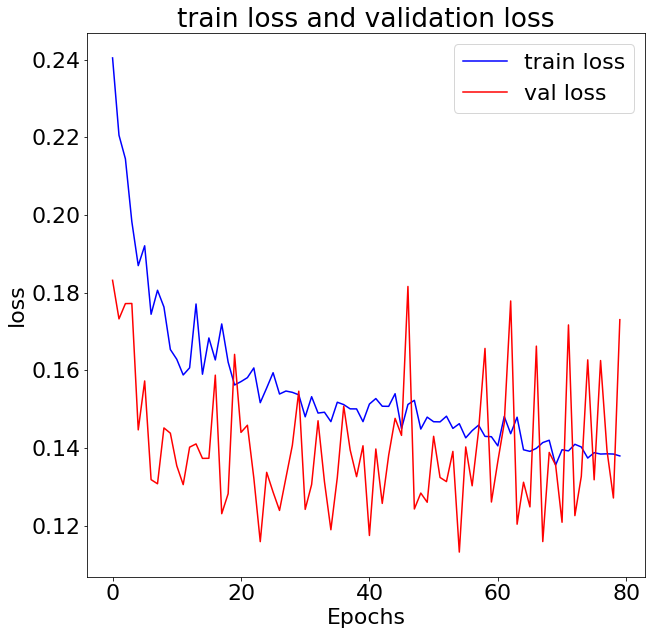

In [7]:
from util import plot
plot(train_loss_list[:80],val_loss_list[:80],'train loss','val loss','loss','train loss and validation loss')

In [9]:
from util import my_img_plot
import gc
gc.collect() 
torch.cuda.empty_cache()
device = torch.device('cuda:0')
model = torch.load('./models/final.pt').to(device)




<Figure size 432x288 with 0 Axes>

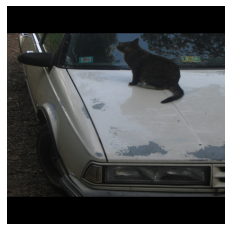

In [28]:

model.eval()
for images, targets in loader_train:
    # for image in images:
    images = images.to(device)
    with torch.no_grad():
        pred = model(images)
        my_img_plot(pred[0],images[0],fil_classes,1)
    break

In [29]:
from util import *

In [50]:
p = pred[0][0]
pc = p[..., 4] > 0.015

In [51]:
p[pc][..., 4]

tensor([0.0164, 0.0152, 0.0159, 0.0153, 0.0156], device='cuda:0')

In [52]:
px = p[pc][:,:4]

In [53]:
px = px.cpu().detach().numpy()

In [54]:
img = images[0].cpu().detach().numpy().transpose(1,2,0)

In [55]:
img.shape

(480, 480, 3)

<Figure size 432x288 with 0 Axes>

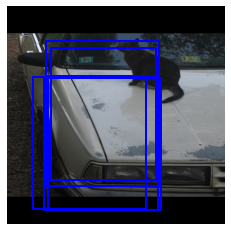

In [56]:
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)



for x, y, w, h in px:
    

    # Create a Rectangle patch
    bbox = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=2, edgecolor='blue', facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)


# Save generated image with detections
plt.axis("off")
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())
plt.show()



In [ ]:
def my_img_plot(pred,img,fil_classes,scaling_factor):
  
    detections = non_max_suppression(pred, conf_thres=0.03, iou_thres=0.1,max_det=300)[0].cpu().detach().numpy()
    img = img.cpu().detach().numpy().transpose(1,2,0)
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    unique_labels = np.unique(detections[:, -1])
    n_cls_preds = len(unique_labels)
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)

    for x1, y1, x2, y2, conf, cls_pred in detections:

        print(f"\t+ Label: {fil_classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")

        box_w = (x2 - x1)
        box_h = (y2 - y1)
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=fil_classes[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

        # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.show()

In [ ]:
def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates
    

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    min_wh, max_wh = 2, 320  # (pixels) minimum and maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = False  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence
        print(x.shape)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output